In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sarikagpawaar","key":"db82d07489d7cf18210714e7e0820b61"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d gti-upm/leapgestrecog

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
 99% 2.11G/2.13G [00:13<00:00, 317MB/s]
100% 2.13G/2.13G [00:13<00:00, 169MB/s]


In [4]:
!unzip leapgestrecog.zip

Streaming output truncated to the last 5000 lines.
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapgestrecog/leapGestRe

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [11]:
def load_images(folder_path, img_size=64):
    images, labels = [], []
    for person in os.listdir(folder_path):
        person_folder = os.path.join(folder_path, person)
        if not os.path.isdir(person_folder):
            continue
        for gesture_class in os.listdir(person_folder):
            class_folder = os.path.join(person_folder, gesture_class)
            if not os.path.isdir(class_folder):
                continue
            for img_file in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (img_size, img_size))
                    images.append(img)
                    labels.append(gesture_class)  # label is gesture name
    return np.array(images), np.array(labels)


In [8]:
import os

for root, dirs, files in os.walk('leapGestRecog'):
    print("Current folder:", root)
    print("Subfolders:", dirs)
    print("Files:", files[:5])  # only show first 5 files
    print()


Current folder: leapGestRecog
Subfolders: ['08', '03', '09', '01', '02', '07', '06', '00', '05', '04']
Files: []

Current folder: leapGestRecog/08
Subfolders: ['06_index', '02_l', '09_c', '01_palm', '03_fist', '05_thumb', '04_fist_moved', '07_ok', '10_down', '08_palm_moved']
Files: []

Current folder: leapGestRecog/08/06_index
Subfolders: []
Files: ['frame_08_06_0097.png', 'frame_08_06_0011.png', 'frame_08_06_0034.png', 'frame_08_06_0104.png', 'frame_08_06_0038.png']

Current folder: leapGestRecog/08/02_l
Subfolders: []
Files: ['frame_08_02_0122.png', 'frame_08_02_0007.png', 'frame_08_02_0010.png', 'frame_08_02_0015.png', 'frame_08_02_0056.png']

Current folder: leapGestRecog/08/09_c
Subfolders: []
Files: ['frame_08_09_0071.png', 'frame_08_09_0139.png', 'frame_08_09_0132.png', 'frame_08_09_0054.png', 'frame_08_09_0167.png']

Current folder: leapGestRecog/08/01_palm
Subfolders: []
Files: ['frame_08_01_0152.png', 'frame_08_01_0036.png', 'frame_08_01_0139.png', 'frame_08_01_0144.png', 'fr

In [12]:
X, y = load_images('leapGestRecog')

# Normalize
X = X / 255.0
X = X.reshape(-1, 64, 64, 1)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [15]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_categorical.shape[1], activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 74s 179ms/step - accuracy: 0.6009 - loss: 1.1540 - val_accuracy: 0.9947 - val_loss: 0.0309
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 81s 177ms/step - accuracy: 0.9675 - loss: 0.1020 - val_accuracy: 0.9969 - val_loss: 0.0132
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 80s 173ms/step - accuracy: 0.9843 - loss: 0.0488 - val_accuracy: 0.9981 - val_loss: 0.0092
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 85s 180ms/step - accuracy: 0.9911 - loss: 0.0296 - val_accuracy: 0.9987 - val_loss: 0.0036
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 83s 183ms/step - accuracy: 0.9907 - loss: 0.0276 - val_accuracy: 0.9994 - val_loss: 0.0019
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 80s 177ms/step - accuracy: 0.9888 - loss: 0.0323 - val_accuracy: 0.9991 - val_loss: 0.0049
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 81s 175ms/step - accuracy: 0.9957 - loss: 0.0138 - val_accuracy: 0.9997 - val_loss: 0.0016
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 70s 175ms/step - accuracy: 0.9929 - loss: 0

In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9997 - loss: 9.3839e-04
Test Accuracy: 99.95%


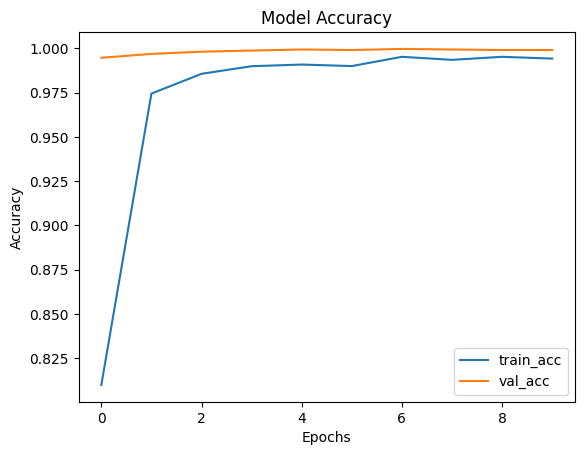

In [18]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


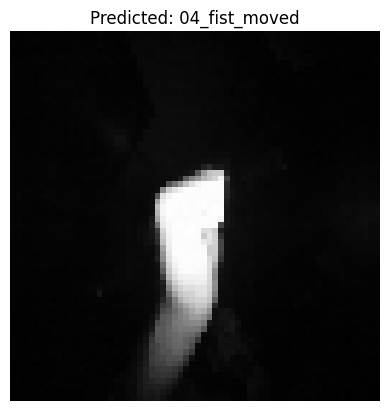

In [20]:
import random

i = random.randint(0, len(X_test)-1)
sample = X_test[i].reshape(1, 64, 64, 1)
pred = model.predict(sample)
predicted_label = le.inverse_transform([np.argmax(pred)])

plt.imshow(X_test[i].reshape(64, 64), cmap='gray')
plt.title(f"Predicted: {predicted_label[0]}")
plt.axis('off')
plt.show()


In [22]:
model.save('hand_gesture_model.keras')
